### Bar plot of Figure of Merit for WFD

- [time gaps](#time-gaps)
- [depth](#depth)
- [footprint](#footprint)
- [proper motion](#proper-motion)
- [all](#all)

In [1]:
pwd

'/home/idies/workspace/Storage/lixl/persistent/LSSTunknowns/tdAnom'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
plt.style.use('seaborn')
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.facecolor'] = "w"


In [4]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
cols_all = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

cols_same = [ 'uu',  'gg',  'rr',  'ii',  'zz',  'yy']

cols_diff = ['ug', 'ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy']


In [5]:
def scale(arr, mode=0, fmax=1):
    """scale array by max, or given fmax"""
    
    newarr = arr / arr.max()
    if mode==1:
        # scale to 0-1
        newarr = (arr - arr.min()) / (arr.max()-arr.min())
    elif mode==2:
        # scale input max
        newarr = arr / fmax
        
    return newarr

def get_family(df):
    """get family of opsim"""
    
    return df['db'].split('_')[0]



In [6]:
def get_df_norm(df=[], cols=['u'], fomcsv = 'df_tgapsFoM_GP.csv', mode=0, fmax=1):
    """
    Input: dataframe or csvfile
    return normalized dataframe
    cols: columns to normalize
    """
    
    if len(df)!=0:
        df_fom = df.copy()
    else:
        df_fom = pd.read_csv(fomcsv)
    
    if 'db' not in df_fom.columns:
        df_fom['db'] = dblist_all
        
    # scale fom table to 0 and 1
    if 'prop' in df_fom.columns:
        df_new = df_fom[ ['db', 'prop'] ].copy()
    else:
        df_new = df_fom[ ['db'] ].copy()
    
    for col in cols:
        # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
        df_new[col] = scale(df_fom[col], mode=mode, fmax=fmax) 
        
    df_new['db'] = df_new['db'].apply(lambda x: x.replace(".db", "") )

    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5_10yrs", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.5_10yrs", "") )
    
    
    df_new['family'] = df_new.apply(get_family, axis=1)
    
    return df_new



In [7]:
# get the name of all opsim dbs 
import os
import glob

workpath = os.getcwd()
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases
os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps'
os.chdir(workpath) # change back to work directory
dblist_all.sort()


In [8]:
#dblist_all

In [8]:
def plot_barh(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", **kwargs):
    """barh plot of FoM"""

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'],)
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmean', 'total'], ascending=[True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    
    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')


def get_mycmap(pairs='diff'):
    """discrete colormap for filter pairs"""
    import numpy as np
    import matplotlib.colors as mcolors
    
    # colors in total
    # combine them and build a new colormap

    thecbases = [plt.cm.Blues,
                 plt.cm.Greens,
                 plt.cm.Purples,
                 plt.cm.Reds,
                 plt.cm.YlOrBr,
                 (240./255,230./255,140./255, 1.),
                ]

    grad = [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    
    #thecmaps = {'diff': , [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    #                'same':[thecbases[i](np.linspace(0, 1, 7-i)[-3 if i < 2 else -2]) 
    #                     for i in range(5)] + [thecbases[5]]}
    
    thecmaps = {'diff': [ grad[i] [ 1:6 - i ] for i in range(5) ] ,
                'same':[ grad[i] [ 1 if i!=5 else 0 ] for i in range(5) ] + [thecbases[5]]}
    
    colors = np.vstack( [c for c in thecmaps[pairs]] )
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
            
    #plt.pcolor(data, cmap=mymap)
    #plt.colorbar()
    #plt.show()
    return mymap



In [9]:
def plot_barh_v2(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", title='', **kwargs):
    """barh plot of FoM"""

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'],)
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmean', 'total'], ascending=[True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    ax.set_title(title)
    
    # modify labels
    for tl in ax.get_yticklabels():
        txt = tl.get_text()
        if 'v1.7' in txt:
            #txt += ' (!)'
            #tl.set_backgroundcolor('C3')
            #tl.set_backgroundcolor("#FF9398")
            tl.set_backgroundcolor("#E5E7E9")
        if 'baseline' in txt:
            #tl.set_backgroundcolor("#FF9398")
            tl.set_fontweight('bold') 
            
        #tl.set_text(txt)
    
    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')
        

### time gaps

In [10]:
fomcsv = './data_v1_5/df_tgapsFoM_wfd.csv'
df_norm = get_df_norm(fomcsv = fomcsv, cols=cols_all, mode=0)


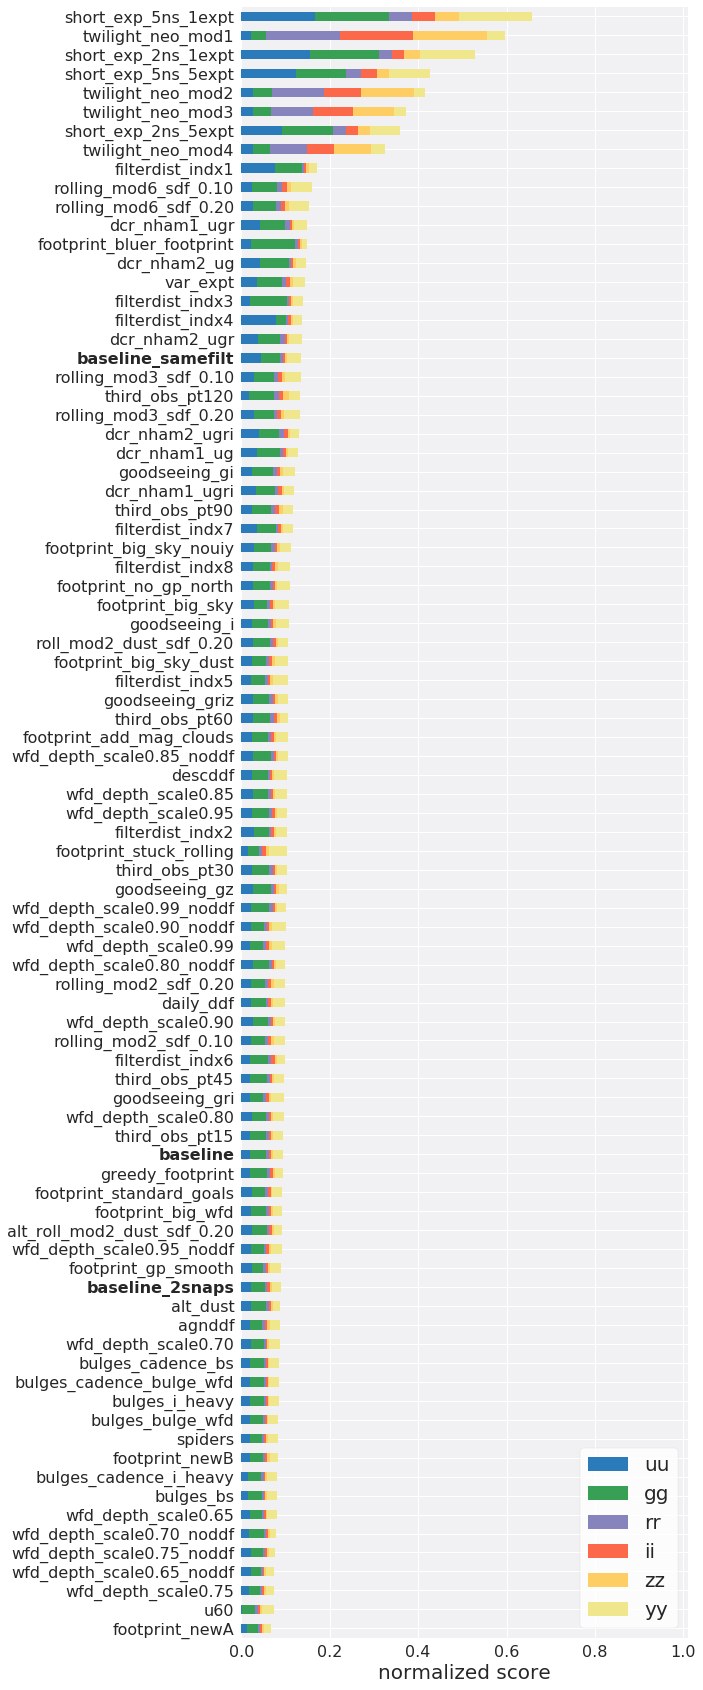

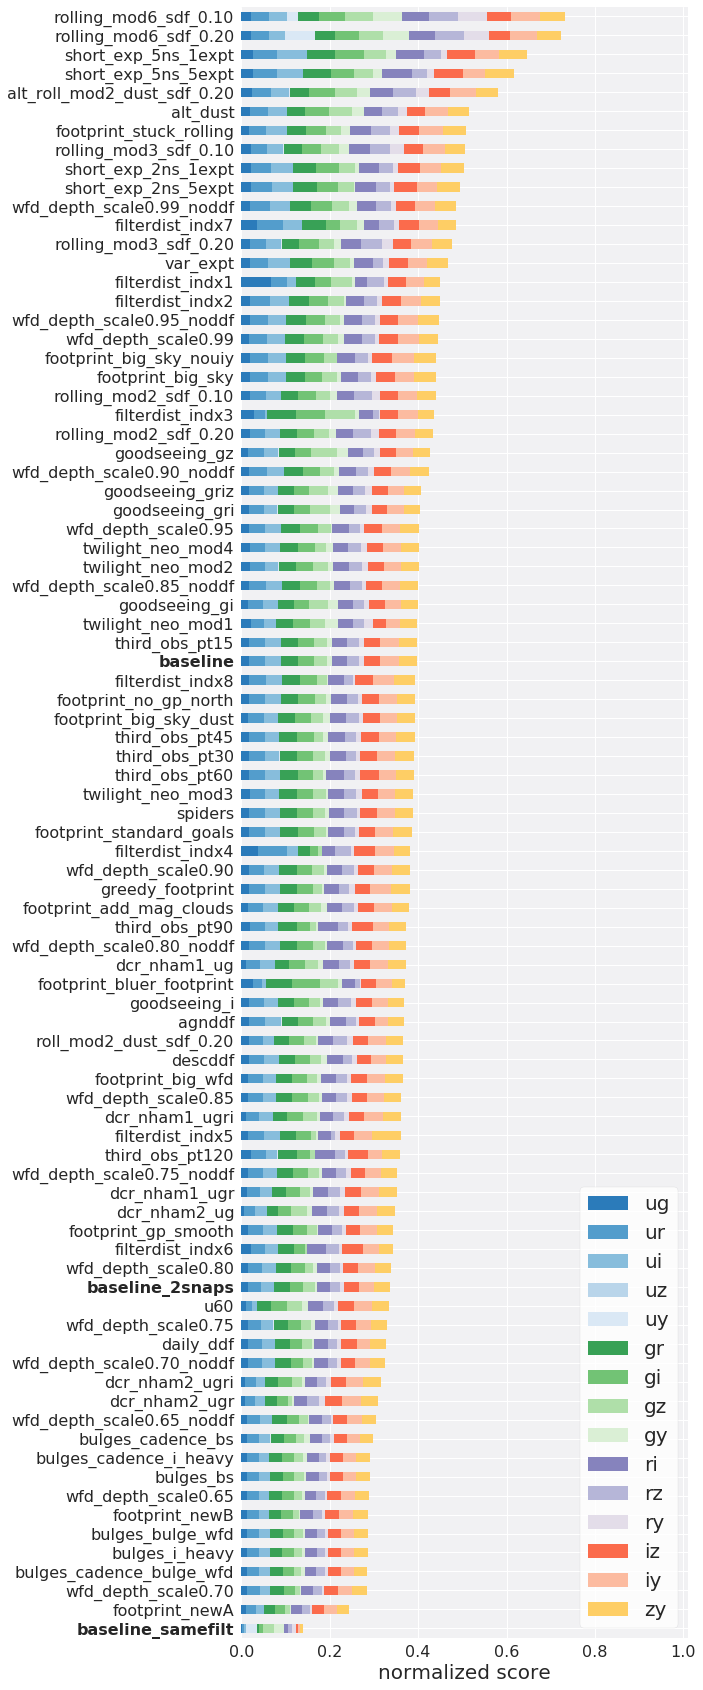

In [15]:
plot_barh_v2(df_norm, colon=cols_same, byfamily=False, savefig='figures/barh_tgaps_same_wfd.pdf', colormap=get_mycmap(pairs='same')) 
plot_barh_v2(df_norm, colon=cols_diff, byfamily=False, savefig='figures/barh_tgaps_diff_wfd.pdf', colormap=get_mycmap(pairs='diff') ) 



### depth

In [20]:
mag_stretch = {'u':24.0, 'g':25.1, 'r':24.8, 'i':24.1, 'z':23.4, 'y':22.2 }


In [32]:
mag_stretch = {'u':24.2, 'g':25.1, 'r':24.8, 'i':24.1, 'z':23.4, 'y':22.2 }


In [70]:
df_mag = pd.read_csv('./data_v1_5/df_depth_wfd.csv')


In [71]:
# get difference to goal
for f in filters:
    df_mag[f] = df_mag[f] - mag_stretch[f]

In [74]:
for f in filters:
    df_mag[f] = df_mag[f] + 2.8

In [42]:
df_mag.max()

db    wfd_depth_scale0.99_v1.5_10yrs.db
g                             -0.462413
i                             -0.542281
r                              -0.71213
u                            -0.0487104
y                             -0.147285
z                             -0.542774
dtype: object

In [75]:
df_norm = get_df_norm(df = df_mag, cols=filters, mode=0)



In [18]:
#fomcsv = './data_v1_5/df_depth_wfd.csv'
#df_norm = get_df_norm(fomcsv = fomcsv, cols=filters, mode=1)
#

In [79]:
dblist_all

['agnddf_v1.5_10yrs.db',
 'alt_dust_v1.5_10yrs.db',
 'alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db',
 'baseline_2snaps_v1.5_10yrs.db',
 'baseline_samefilt_v1.5_10yrs.db',
 'baseline_v1.5_10yrs.db',
 'bulges_bs_v1.5_10yrs.db',
 'bulges_bulge_wfd_v1.5_10yrs.db',
 'bulges_cadence_bs_v1.5_10yrs.db',
 'bulges_cadence_bulge_wfd_v1.5_10yrs.db',
 'bulges_cadence_i_heavy_v1.5_10yrs.db',
 'bulges_i_heavy_v1.5_10yrs.db',
 'daily_ddf_v1.5_10yrs.db',
 'dcr_nham1_ug_v1.5_10yrs.db',
 'dcr_nham1_ugr_v1.5_10yrs.db',
 'dcr_nham1_ugri_v1.5_10yrs.db',
 'dcr_nham2_ug_v1.5_10yrs.db',
 'dcr_nham2_ugr_v1.5_10yrs.db',
 'dcr_nham2_ugri_v1.5_10yrs.db',
 'descddf_v1.5_10yrs.db',
 'filterdist_indx1_v1.5_10yrs.db',
 'filterdist_indx2_v1.5_10yrs.db',
 'filterdist_indx3_v1.5_10yrs.db',
 'filterdist_indx4_v1.5_10yrs.db',
 'filterdist_indx5_v1.5_10yrs.db',
 'filterdist_indx6_v1.5_10yrs.db',
 'filterdist_indx7_v1.5_10yrs.db',
 'filterdist_indx8_v1.5_10yrs.db',
 'footprint_add_mag_cloudsv1.5_10yrs.db',
 'footprint_big_sky_d

In [78]:
len(dblist_all)

86

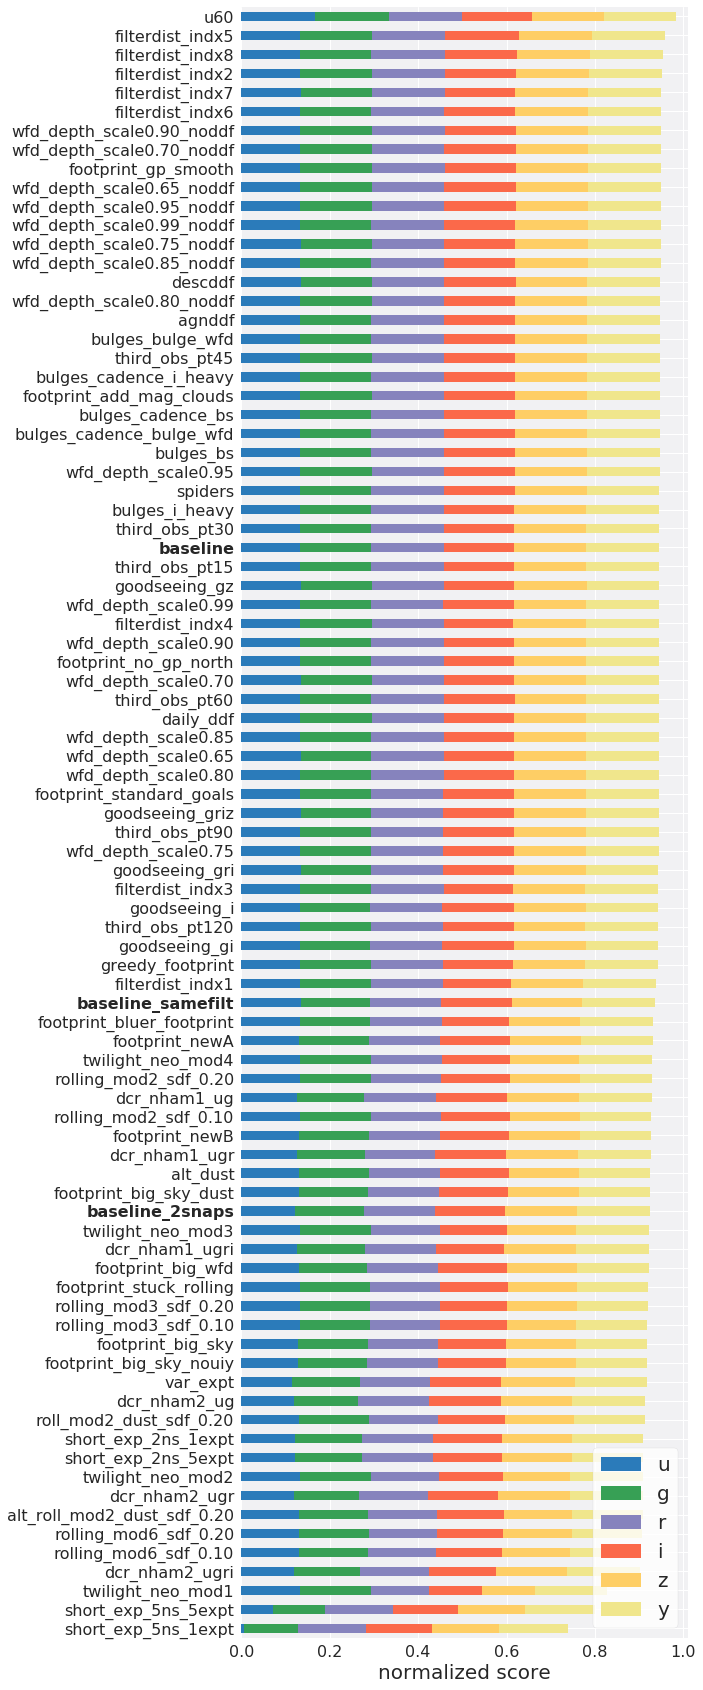

In [76]:
plot_barh_v2(df_norm, colon=filters, byfamily=False, savefig='figures/barh_depth_wfd.pdf', colormap=get_mycmap(pairs='same')) 



### footprint

In [51]:
fomcsv = './data_v1_5/df_Nfields_wfd_2d.csv'

df_fields = pd.read_csv(fomcsv)
df_fields['db'] = dblist_all

In [53]:
df_fields.max()

db    wfd_depth_scale0.99_v1.5_10yrs.db
uu                                 1359
ug                                 1359
ur                                 1347
ui                                 1275
uz                                 1274
uy                                 1246
gg                                 1353
gr                                 1345
gi                                 1328
gz                                 1268
gy                                 1132
rr                                 1340
ri                                 1347
rz                                 1340
ry                                 1327
ii                                 1340
iz                                 1343
iy                                 1325
zz                                 1342
zy                                 1343
yy                                 1339
dtype: object

In [43]:
df_fields.iloc[5]

uu                      1458
ug                      1458
ur                      1456
ui                      1435
uz                      1212
uy                       584
gg                      1458
gr                      1459
gi                      1447
gz                      1417
gy                      1309
rr                      1459
ri                      1461
rz                      1436
ry                      1418
ii                      1460
iz                      1460
iy                      1448
zz                      1460
zy                      1459
yy                      1460
db    baseline_v1.5_10yrs.db
Name: 5, dtype: object

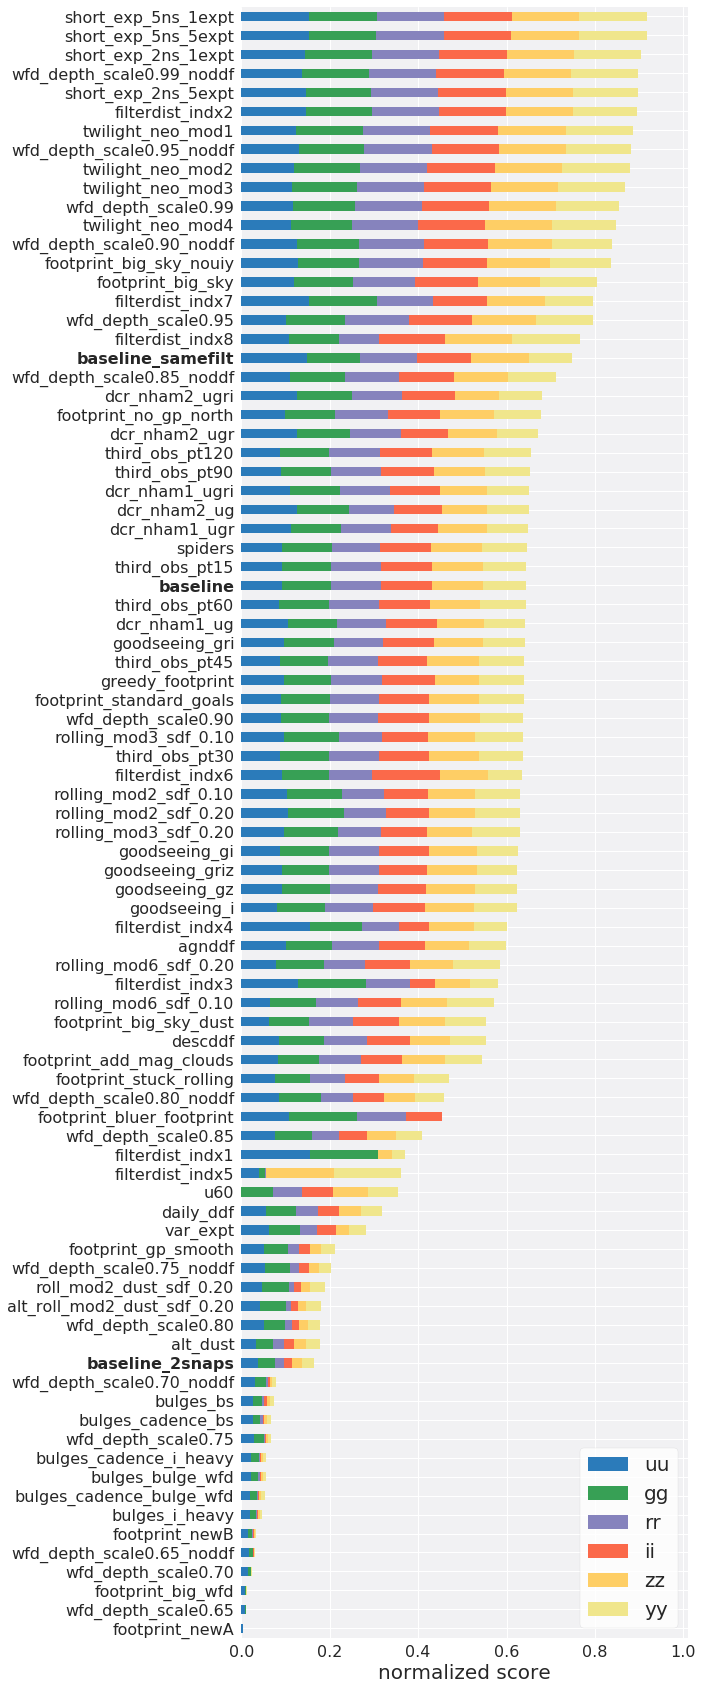

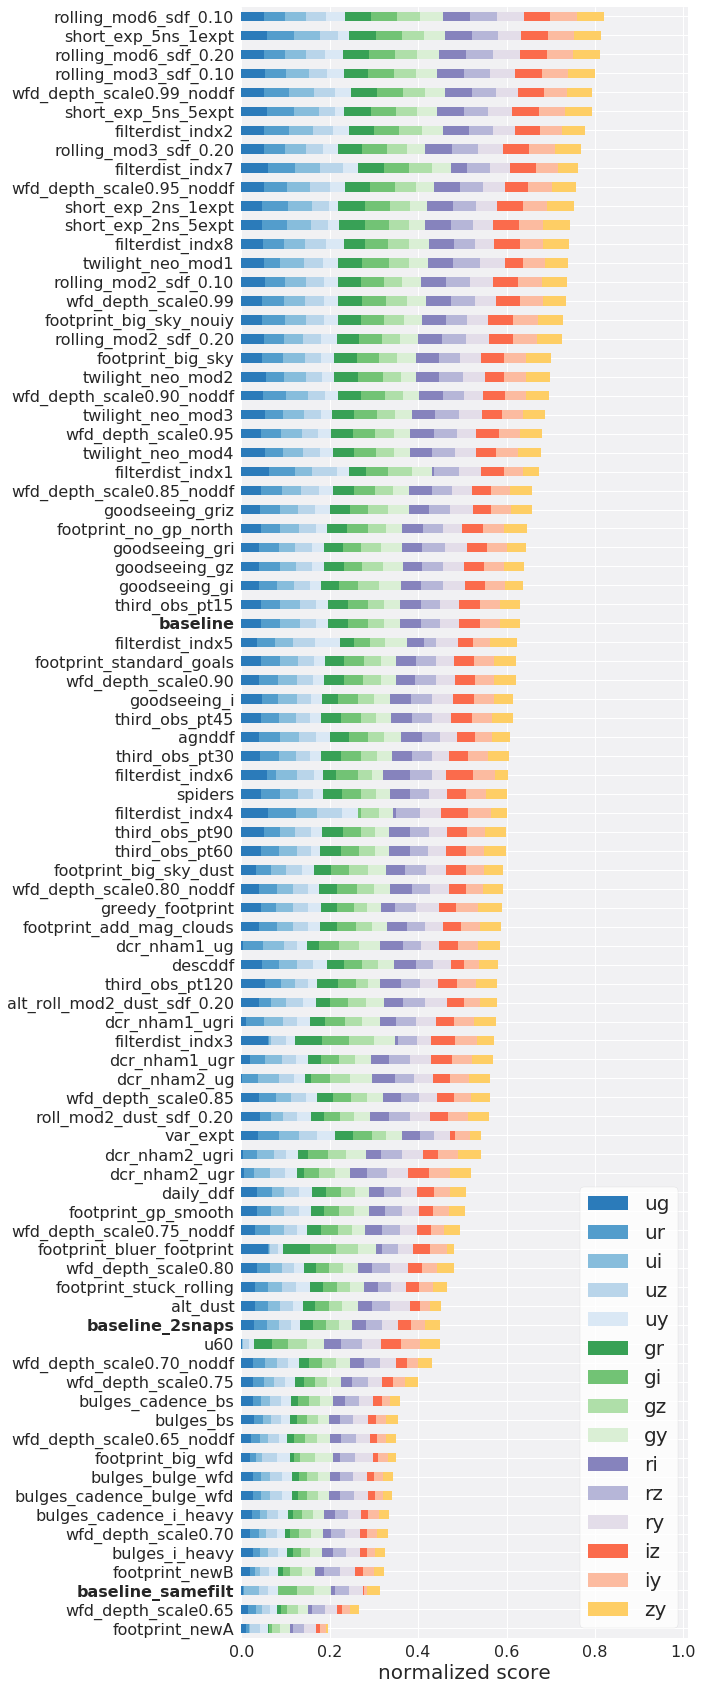

In [45]:
fomcsv = './data_v1_5/df_Nfields_wfd_2d.csv'

df_fields = pd.read_csv(fomcsv)


df_norm = get_df_norm(df=df_fields, cols=cols_all, mode=2, fmax=1460)

plot_barh_v2(df_norm, colon=cols_same, byfamily=False, savefig='figures/barh_nfields_same_wfd.pdf', colormap=get_mycmap(pairs='same')) 
plot_barh_v2(df_norm, colon=cols_diff, byfamily=False, savefig='figures/barh_nfields_diff_wfd.pdf', colormap=get_mycmap(pairs='diff') ) 



### star density

In [52]:
fomcsv = './data_v1_5/df_Nstars_wfd_2d_raw.csv'

df_stars = pd.read_csv(fomcsv)
df_stars['db'] = dblist_all

In [53]:
df_stars.iloc[5]

uu                 119952437
ug                 119291587
ur                 117414258
ui                 109571873
uz                  91980208
uy                  37839115
gg                 119941489
gr                 121624878
gi                 112292891
gz                 108483642
gy                  99761408
rr                 121639976
ri                 124058572
rz                 110191717
ry                 106276948
ii                 122898774
iz                 122876537
iy                 111619354
zz                 122871842
zy                 120937177
yy                 122802388
db    baseline_v1.5_10yrs.db
Name: 5, dtype: object

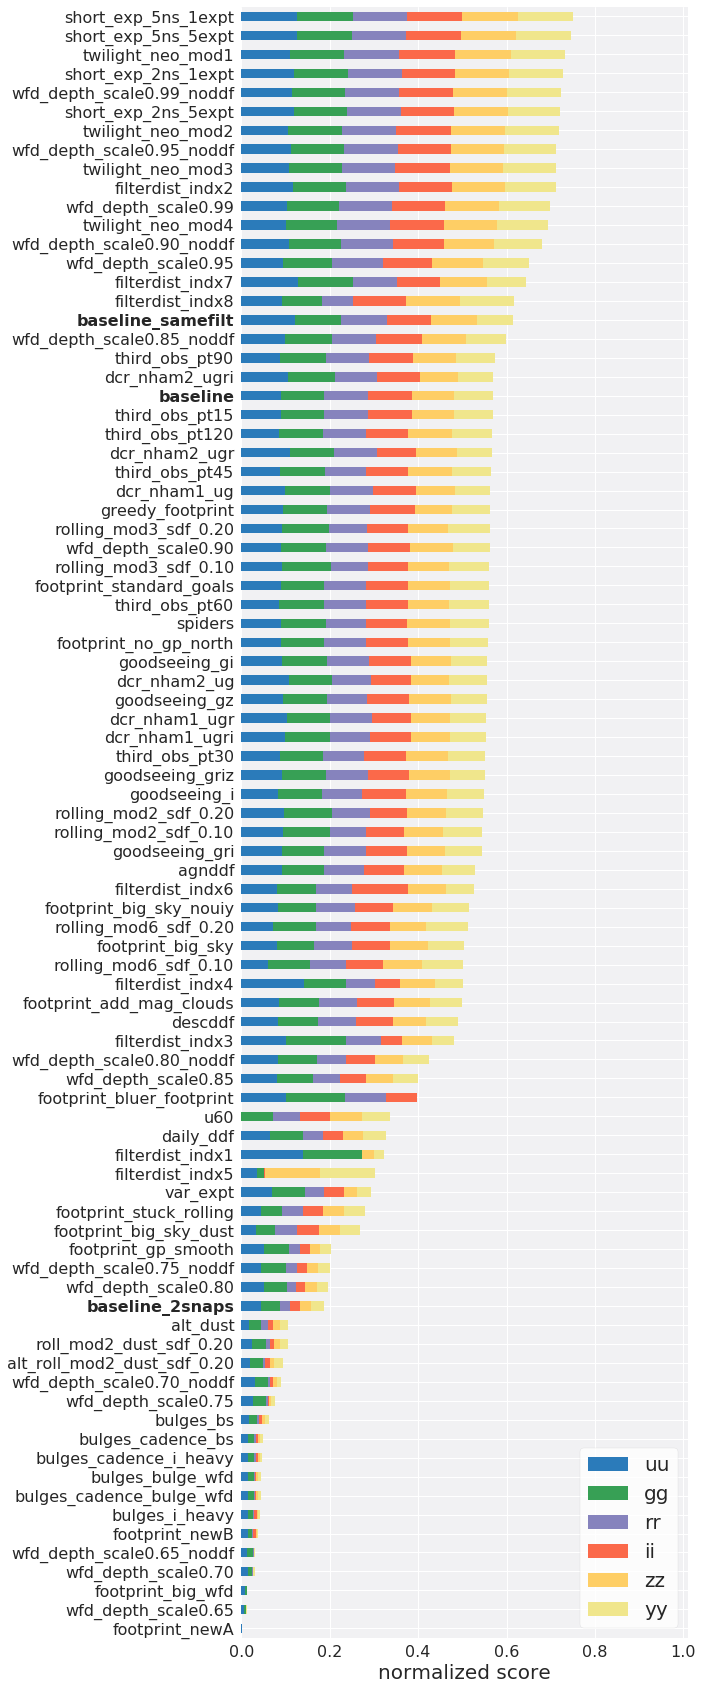

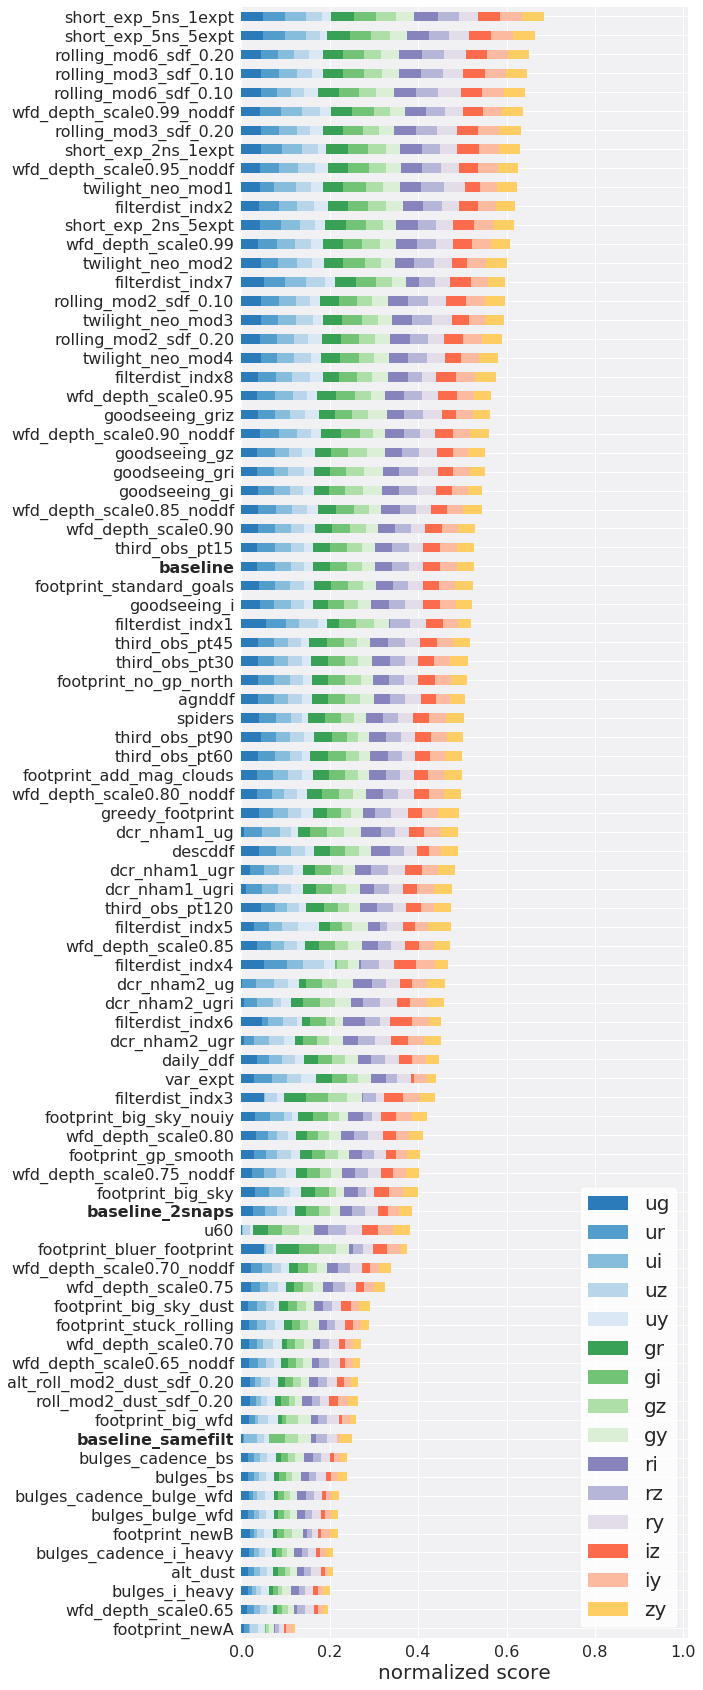

In [54]:
fomcsv = './data_v1_5/df_Nstars_wfd_2d.csv'
df_norm = get_df_norm(fomcsv = fomcsv, cols=cols_all, mode=2, fmax=122876537)

plot_barh_v2(df_norm, colon=cols_same, byfamily=False, savefig='figures/barh_nstars_same_wfd.pdf', colormap=get_mycmap(pairs='same')) 
plot_barh_v2(df_norm, colon=cols_diff, byfamily=False, savefig='figures/barh_nstars_diff_wfd.pdf', colormap=get_mycmap(pairs='diff') ) 



### proper motion

### prepare df_radar

In [101]:

# for proposalId=1 wfd
#df_tgaps = pd.read_csv('./data_v1_5/df_tgapsFoM_wfd.csv')
#df_nfields = pd.read_csv('./data_v1_5/df_Nfields_wfd_2d.csv')
#df_nstars = pd.read_csv('./data_v1_5/df_Nstars_wfd_2d.csv')
#df_depth = pd.read_csv('./data_v1_5/df_depth_wfd.csv')

# for all
df_tgaps = pd.read_csv('./data_v1_5/df_tgapsFoM_all_noddf.csv')
df_nfields = pd.read_csv('./data_v1_5/df_Nfields_all_2d.csv')
df_nstars = pd.read_csv('./data_v1_5/df_Nstars_all_2d.csv')
df_depth = pd.read_csv('./data_v1_5/df_depth_all.csv')



In [102]:
# normalize
for col in cols_all:
    # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
    df_tgaps[col] = scale(df_tgaps[col], mode=0)
    df_nfields[col] = scale(df_nfields[col], mode=2, fmax=1460)
    df_nstars[col] = scale(df_nstars[col], mode=2, fmax=122876537)

for col in filters:
    df_depth[col] = scale(df_depth[col], mode=1)

df_tgaps['total_same'] = scale( np.sum(df_tgaps[ cols_same ], axis=1) )
df_tgaps['total_diff'] = scale( np.sum(df_tgaps[ cols_diff ], axis=1) )
df_nfields['total'] = scale( np.sum(df_nfields[ cols_all ], axis=1) )
df_nstars['total'] = scale( np.sum(df_nstars[ cols_all ], axis=1) )
df_depth['total'] = scale( np.sum(df_depth[ filters ], axis=1) )



In [58]:
def show_opsims(dbDir):
    '''Show available opsim databases in the provided directory.

    Args:
        dbDir(str): The path the database directory.
    '''

    dbDir = os.path.abspath(dbDir)
    db_list = glob.glob(dbDir+'/*.db')
    runNames = [os.path.splitext(os.path.basename(x))[0] for x in db_list]

    return runNames

runNames = show_opsims(dbpath)
runNames.sort()

In [103]:
msname = 'all'
df_radar = pd.DataFrame()
df_radar['db'] = runNames

df_radar['flux change'] = df_tgaps['total_same'] 
df_radar['color'] = df_tgaps['total_diff'] 

df_radar['footprint'] = df_nfields['total']
df_radar['star count'] = df_nstars['total']
df_radar['depth'] = df_depth['total']
df_radar['family'] = df_radar.apply(get_family, axis=1)

# save file 
df_radar.to_csv('./data_v1_5/df_radar_{}.csv'.format(msname), index=False)

### all by family

In [104]:
fomcsv = './data_v1_5/df_radar_all.csv'
df_fom = pd.read_csv(fomcsv)
df_fom['family'] = df_fom.apply(get_family, axis=1)

df_fom.head()

,db,flux change,color,footprint,star count,depth,family
0,agnddf_v1.5_10yrs,0.145183,0.526600,0.687478,0.294358,0.943507,agnddf
1,alt_dust_v1.5_10yrs,0.152272,0.751096,0.449416,0.140130,0.865168,alt
2,alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs,0.157885,0.850064,0.554915,0.159610,0.810365,alt
3,baseline_2snaps_v1.5_10yrs,0.139289,0.484341,0.423033,0.222321,0.900398,baseline
4,baseline_samefilt_v1.5_10yrs,0.206147,0.207056,0.513425,0.275975,0.908902,baseline


In [99]:
#FoMvars = ['FoM_tgaps_same','FoM_tgaps_diff', 'FoM_depth', 'FoM_EG', 'FoM_Gal',]

FoMvars = ['flux change','color', 'depth', 'footprint', 'star count',]



In [63]:
import matplotlib.colors as mcolors
colors = plt.cm.tab10( np.linspace(0., 1, 10) )[:5]
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)


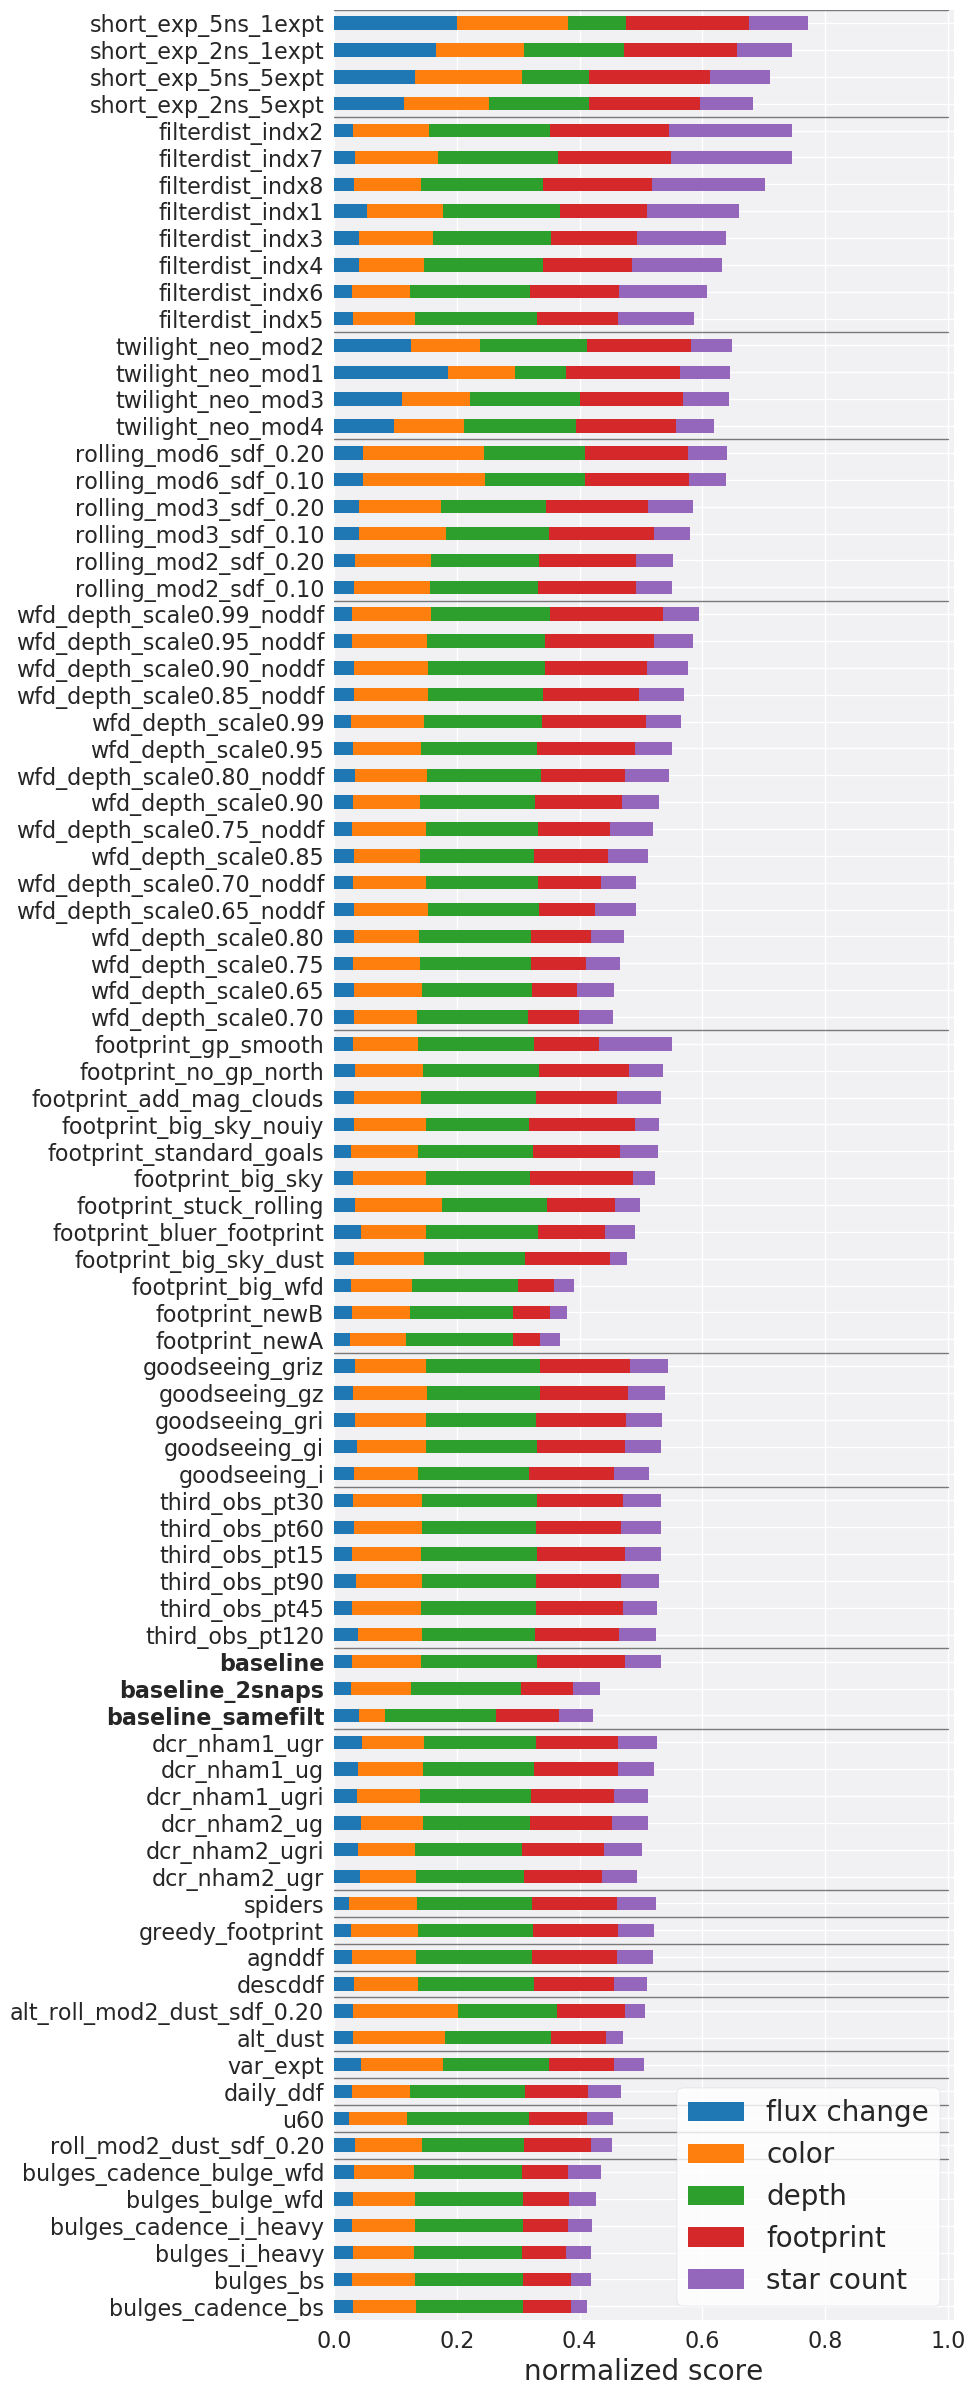

In [105]:
fomcsv = './data_v1_5/df_radar_all.csv'
#fomcsv = './data_v1_5/df_Nstars_wfd.csv'

df_norm = get_df_norm(fomcsv=fomcsv , cols=FoMvars)


plot_barh_v2(df_norm, colon=FoMvars, byfamily=True, savefig='figures/barh_family_all.pdf', colormap=mymap ) 


In [12]:
df_norm.head()

,db,FoM_tgaps_same,FoM_tgaps_diff,FoM_depth,FoM_EG,FoM_Gal,family
0,agnddf,0.132988,0.503818,0.931742,0.564762,0.604740,agnddf
1,alt_dust,0.133044,0.703636,0.800220,0.554701,0.340651,alt
2,alt_roll_mod2_dust_sdf_0.20,0.138956,0.795575,0.692088,0.644424,0.404541,alt
3,baseline_2snaps,0.135375,0.461125,0.863893,0.330473,0.379226,baseline
4,baseline_samefilt,0.206479,0.190582,0.866805,0.357034,0.352019,baseline


### plot radar

In [66]:
def plot_radar(r, ax=None, fill=True, figsize=(6,6), **kwargs):
    """plot a radar 
    Inputs: r, list like"""
    
    if ax==None:
        fig, ax = plt.subplots(1,1,figsize=figsize, subplot_kw={'projection': 'polar'} )
    
    r = list(r)
    N = len(r)
    r.append( r[0] )  # repeat first to close circle

    # get angle for each value
    theta = [n * 2 * np.pi / N  for n in range(N) ]
    theta.append( theta[0] )
    
    ax.plot(theta, r, **kwargs)
    if fill:
        ax.fill(theta, r, alpha=0.1)
    ax.set_xticks(theta[:-1], );
    #ax.set_xticklabels( ['v1', 'v2'] );
    ax.spines['polar'].set_visible(False)  # 不显示极坐标最外圈的圆
    return ax
    




In [108]:
msname = 'wfd'
fomcsv = './data_v1_5/df_radar_wfd.csv'

df_radar = pd.read_csv(fomcsv)


[1.         0.88405441 0.35864895 1.         1.        ]
[0.1536691  0.66336798 0.94213813 0.97581144 0.9402912 ]
[0.1567001  0.61472782 0.96323842 0.9612442  0.91806444]
[0.2414304  1.         0.67459161 0.8877898  0.85634871]
[0.63196712 0.54912376 0.75989383 0.88867852 0.9006751 ]


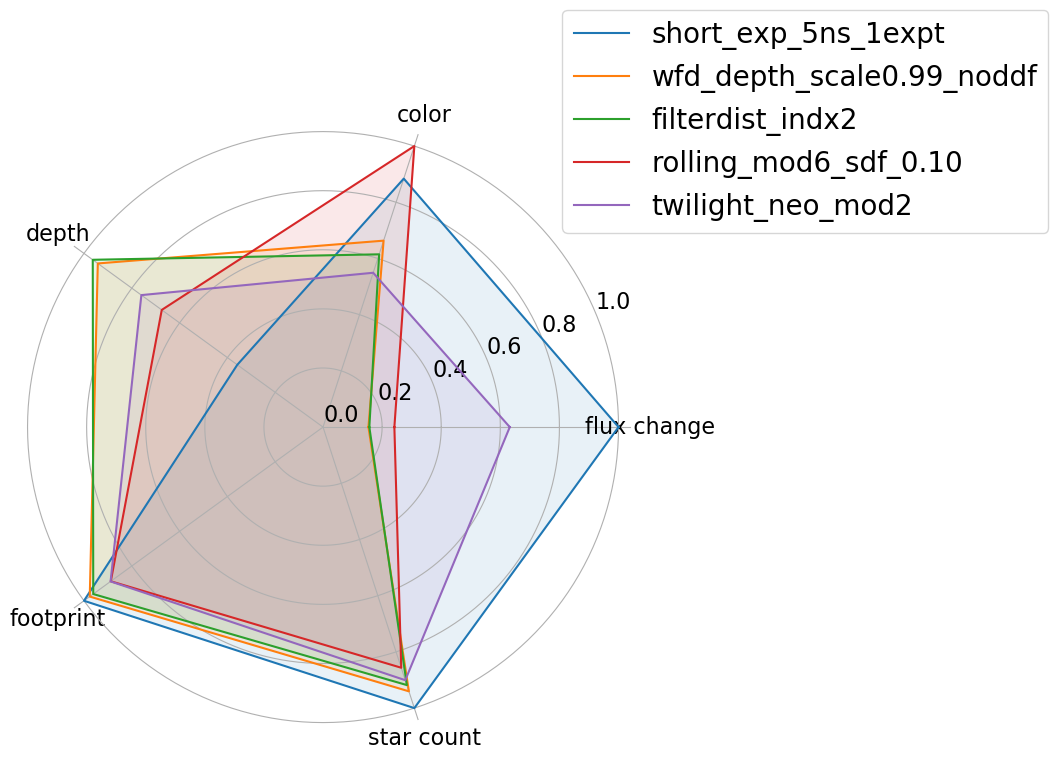

In [109]:
plt.style.use('default')
#plt.style.use('seaborn')
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

dbnames = [ #'baseline_v1.5_10yrs', 'footprint_big_skyv1.5_10yrs',
           #'twilight_neo_mod1_v1.5_10yrs',
           #'wfd_depth_scale0.99_v1.5_10yrs'
           'short_exp_5ns_1expt_v1.5_10yrs',
           'wfd_depth_scale0.99_noddf_v1.5_10yrs',
           #'bulges_bs_v1.5_10yrs',
           'filterdist_indx2_v1.5_10yrs',
           'rolling_mod6_sdf_0.10_v1.5_10yrs',
           'twilight_neo_mod2_v1.5_10yrs',
           #'footprint_big_sky_nouiyv1.5_10yrs'  
          ]

#FoMvars = ['FoM_tgaps_same', 'FoM_tgaps_diff', 'FoM_depth', 'FoM_EG', 'FoM_Gal', ]

FoMvars = ['flux change', 'color', 'depth', 'footprint', 'star count', ]


fig, ax = plt.subplots(1,1,figsize=(8,8), subplot_kw={'projection': 'polar'} )

for dbname in dbnames:
    r = df_radar[ df_radar.db==dbname ][FoMvars].values.flatten()
    print(r)
    label = dbname.replace("_v1.5_10yrs", "").replace("v1.5_10yrs", "")
    ax = plot_radar(r=r, label=label, fill=True, ax=ax)

FoMvarsnames = ['flux change', 'color', 'depth', 'footprint', 'star count', ]
ax.set_xticklabels(FoMvarsnames, );
ax.set_yticks([0, .2, .4, .6, .8, 1])
#ax.set_rlabel_position(0)
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1.2))

plt.savefig("figures/radar_{}.pdf".format(msname), bbox_inches='tight')


